<a href="https://colab.research.google.com/github/alexk2206/tds_capstone/blob/Alex-DEV/Capstone_Project_Topics_in_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - Topics in Data Science

In this notebook, we provide an overview of the project and our approach. A rough summary outlines our thoughts and chosen solution. Throughout, we share insights and code snippets, with further details available in the referenced notebooks for each section.

Created by: Dominik Schuster & Alexander Keßler

In [ ]:
#!pip install evaluate
import pandas as pd
import json
import random
from itertools import chain, combinations
from datetime import datetime, timedelta
import evaluate
from evaluate.visualization import radar_plot
import matplotlib.pyplot as plt
import seaborn as sns
import requests

random_state = 1

# Chapter 1: Getting familiar with provided data

> Referred notebook: Question_type_identification.ipynb

First, we familiarized ourselves with the provided data by accumulating the questionnaires and analyzing the questions and their types. Our goal was to understand both the questions and their distribution. Based on this, we developed a strategy to approach the capstone tasks.

In [ ]:
all_questions_url = 'https://raw.githubusercontent.com/alexk2206/tds_capstone/refs/heads/main/datasets/all_questions.json'
all_questions = pd.read_json(all_questions_url)
all_questions_count = all_questions['type'].value_counts()

print(f'count of question types: \n{all_questions_count}')
all_questions

count of question types: 
type
SINGLE_SELECT    12
MULTI_SELECT      9
TEXT              2
DATE              1
NUMBER            1
Name: count, dtype: int64


,id,type,question,options
0,aa2d8cdd-0758-4035-b0b6-ca18e2f380d8,SINGLE_SELECT,Data processing consent,"Yes, No"
1,12e1ed1d-edaa-4e93-8645-de3850e998f9,SINGLE_SELECT,Customer group,"End User, Wholesaler, Distributor, Consultant,..."
2,625012ae-9192-4cf6-a73d-55e1813d6014,MULTI_SELECT,Products interested in,"MY-SYSTEM, Notion, JTS, JS EcoLine, AKW100, AX100"
3,0699fc5a-34a4-4160-bda1-fb135a3615da,MULTI_SELECT,What kind of follow up is planned,"Email, Phone, Schedule a Visit, No action"
4,815dab84-bc5e-4764-9777-0c0126e3173e,MULTI_SELECT,Who to copy in follow up,"Stephan Maier, Joachim Wagner, Erik Schneider,..."
5,3f34e5b3-1cb0-48ea-93d2-3f21b3371b5d,SINGLE_SELECT,Would you like to receive marketing informatio...,"Yes, No"
6,ba042f33-697e-4c6f-924c-b4de2c30f443,SINGLE_SELECT,What industry are you operating in?,"Aerospace, Computers & Networks, Government, M..."
7,7a776cc0-ffe8-4891-b8a9-dd5ff984de13,MULTI_SELECT,What products are you interested in?,"Automotive radar target simulation, Noise figu..."
8,a0148bc7-15b3-41d5-b97c-6420b8bd927c,TEXT,Notes,Please provide any additional information that...
9,5aefc81d-c5d2-41fc-bc7b-6117d1c7671e,SINGLE_SELECT,What type of company is it?,"Construction company, Craft enterprises, Scaff..."


# Chapter 2: Set up for the Q&A Dataset - Answer combinations

> Referred notebook: answer_combinations.ipynb

After reviewing the questions, we aimed to build a large Q&A dataset by expanding the question set and generating an "intended_answer" for each. This enabled us to pair each question with a predefined answer and create a corresponding context. Our goal was to use a model to extract answers, assess its performance, and fine-tune it accordingly. Our approach varied based on question types:

1. For single-choice questions, we selected one option from the provided choices as the "intended_answer."  
2. For multiple-choice questions, we generated all possible option combinations, making each a separate "intended_answer."  
3. For number questions (which in this case were phone numbers), we used a Python function to generate a valid phone number as the "intended_answer."  
4. For date questions, we used a Python function to create a date within the last two weeks as the "intended_answer."  
5. For text-based questions, we assigned a placeholder string ("Add additional information here") as the "intended_answer."

As mentioned, we extensively discussed the Q&A dataset size and aimed for around a thousand question-answer pairs. To achieve this, we included some duplicate questions but varied the context to enhance model training.  

This chapter will showcase key functions and their results.

## To generate intended answers, these function were used:
- **generate_combinations**: Generates all possible combinations from available options and applies to MULTI_SELECT and SINGLE_SELECT questions.  
- **generate_phone_number**: Generates a random phone number and applies to NUMBER questions.  
- **generate_date**: Generates a date within the last two weeks and applies to DATE questions.  
- **generate_notes**: Sets "Add additional information here" as the intended answer.  


In [ ]:
def generate_combinations(options_list, max_size):
    return list(chain.from_iterable(combinations(options_list, r) for r in range(0, min(len(options_list), max_size) + 1)))


def generate_phone_number():
    phone_prefix = '01' + str(random.randint(100, 999)) + (str(random.randint(0, 9)) if random.random() < 0.5 else '')
    main_number = ''.join([str(random.randint(0, 9)) for _ in range(random.randint(6, 8))])
    phone_number = phone_prefix + main_number
    return [phone_number]


def generate_date(today=None):
    if today is None:
        today = datetime.today()

    random_days = random.randint(0, 13)
    random_date = today - timedelta(days=random_days)

    date = random_date.strftime('%Y-%m-%d')

    return [date]


def generate_notes():
    return ['Add additional information here']

## To process the different types of questions, these functions were used:

- **process_selections**: Applies the `generate_combinations` function to a dataset.  
- **process_freetext**: Applies the functions for other question types accordingly.  

In [ ]:
def process_selections(row, max_size):
    question = row['question']
    options_list = row['options']
    question_type = row['type']
    expanded = []

    if question_type == 'MULTI_SELECT':
        options_combinations = generate_combinations(options_list, max_size=max_size)
        for combo in options_combinations:
            expanded.append({'question': question, 'type': question_type, 'options': options_list, 'intended_answer': list(combo)})

    elif question_type == 'SINGLE_SELECT':
        for option in options_list:
            expanded.append({'question': question, 'type': question_type, 'options': options_list, 'intended_answer': [option]})

    return expanded


def process_freetext(row):
    question = row['question']
    options_list = row['options']
    question_type = row['type']
    expanded = []

    if question_type == 'TEXT':
        expanded.append({'question': question, 'type': question_type, 'options': options_list, 'intended_answer': generate_notes()})

    elif question_type == 'NUMBER':
        expanded.append({'question': question, 'type': question_type, 'options': options_list, 'intended_answer': generate_phone_number()})

    elif question_type == 'DATE':
        expanded.append({'question': question, 'type': question_type, 'options': options_list, 'intended_answer': generate_date()})

    return expanded

## To adjust the number of questions, this function was used:
- **adjust_question_amount**: Ensures each unique question appears between 48 and 64 times to create a larger dataset.  


In [ ]:
def adjust_question_amount(df, column, random_state):
    random.seed(random_state)
    def adjust_group(group):
        max_amount = random.randint(48, 64)

        if len(group) < max_amount:
            return group.sample(n=max_amount, replace=True, random_state=random_state)
        else:
            return group.sample(n=max_amount, random_state=random_state)

    return df.groupby(column, group_keys=False).apply(adjust_group).reset_index(drop=True)

## Answer Combinations Dataset Creation

To obtain the correct amount of questions and diverse intended answers, the functions must be executed in the following order:

1. Split the dataset into selection questions and free text questions.  
2. Create intended answers for selection-type questions.  
3. Scale up free text questions.  
4. Create intended answers for free text questions.  
5. Append the dataset.

After executing these steps, the output looks as follows:


In [ ]:
answer_combinations_url ="https://raw.githubusercontent.com/alexk2206/tds_capstone/refs/heads/main/datasets/answer_combinations.json"
answer_combinations = pd.read_json(answer_combinations_url)

print(f"answer_combinations shape: {answer_combinations.shape}")
answer_combinations.sample(25, random_state = random_state)

answer_combinations shape: (1381, 4)


,question,type,options,intended_answer
989,Notes,TEXT,[Please provide any additional information tha...,[Add additional information here]
991,What is the size of your company?,SINGLE_SELECT,"[1-10, 11-50, 51-200, 201-2000, larger than 2000]",[11-50]
1057,Searches a solution for,MULTI_SELECT,"[Scan business cards, Clean up CRM, Extract da...",[Improve CRM data quality]
1071,What type of company is it?,SINGLE_SELECT,"[Construction company, Craft enterprises, Scaf...",[Craft enterprises]
60,Customer type,SINGLE_SELECT,"[New customer, Existing customer, Partner, App...",[New customer]
750,Which language is wanted for communication?,SINGLE_SELECT,"[German, Italian, Japanese , English, Spanish]",[German]
1276,Any additional notes?,TEXT,[What additional information would you like to...,[Add additional information here]
1347,Size of the trade fair team (on average),SINGLE_SELECT,"[1-5, 6-10, 11-15, 16-20, 21-30, 31-40, more t...",[21-30]
311,Any additional notes?,TEXT,[What additional information would you like to...,[Add additional information here]
670,What is the size of your company?,SINGLE_SELECT,"[1-10, 11-50, 51-200, 201-2000, larger than 2000]",[1-10]


# Chapter 3: Creation of the Q&A dataset


> Referred notebook: QA_Dataset.ipynb

With a dataset containing questions, possible answers and an intended answer we could generate contexts to create a complete Q&A dataset.

For context generation, we used dedicated prompts for different question types and processed them through 'gemini-1.5-flash'. Throughout the process we discovered various challenges but overcame them individually. More on that in our limitations and ideas outline.

**For context generation we used these prompts for each question type, indicated by the functions name:**

generate_selection_answer_easy:

You are asked a question, and you need to provide a natural, conversational answer in the first person. Do not use special characters other than ',' and '.'. Act like you really do not know which options there are and the intended answer is your answer. When given a range, use a number between the two values.  
Be concise but clear, and avoid unnecessary elaboration. Use up to {max_output_tokens} tokens. Question: {question}\n Intended answer: {intended_answer}\n Answer as a sentence, mentioning and explaining all the provided options:

generate_number_answer_easy:

You are asked for contact information, and your response should be clear and concise, as if you're giving someone your phone number and how you can be reached in a conversation. Mention the provided phone number and ensure your response sounds natural and professional. Your answer should be in the first person, present tense, and only include the relevant details. Use up to {max_output_tokens} tokens. Question: {question}\n Intended Answer: {intended_answer}\n Answer as a sentence, providing the phone number and any relevant details:

generate_freetext_answer_easy:

You are asked if you have any additional notes or information to share. Your response should sound natural, in the first person, and can be either brief or more detailed, depending on the situation. You can provide additional information but you don't have to and should mention it clearly and politely. If there isn't anything else to add, express that in a conversational manner. Use up to {max_output_tokens} tokens. Question: {question}\n Intended Answer: {intended_answer}\n Answer as a sentence, providing any additional information or politely stating that there's nothing else to add:

generate_date_answer_easy:

You are asked a question about a specific date, and you need to provide a natural, conversational answer in the first person. Include the date from the intended answer in your response, phrasing it naturally as if you're suggesting a meeting. Be concise but clear, and use up to {max_output_tokens} tokens. Question: {question}\n Intended Answer: {intended_answer}\n Context: Provide a conversational response mentioning the date in a natural way:

We tracked the difficulty for the generated context as 'easy', as we could see making more difficult contexts in the future.

Apart from the prompts, every function that aims to generate context, has the same structure:

In [ ]:
def generate_context(question, intended_answer):
  prompt = f"""
  prompt
  """

  response = model.generate_content(
      contents = prompt,
      generation_config = genai.GenerationConfig(
          max_output_tokens=max_output_tokens,
          temperature=2)
    )

  answer = response.text.strip()

  time.sleep(6)

  return {"answer": answer, "difficulty": "easy"}

After setting up the function for each question type, we looped through every row and used the Gemini API to generate a context using the question and intended answer:

In [ ]:
cycle_count = 0
def generate_answer_for_row(row):
    global cycle_count
    cycle_count += 1
    print(f"Cycle: {cycle_count}")

    question = row['question']
    intended_answer = row['intended_answer']
    question_type = row['type']

    if question_type in ['SINGLE_SELECT', 'MULTI_SELECT']:
        return generate_selection_answer_easy(question, intended_answer)
    elif question_type == 'NUMBER':
        return generate_number_answer_easy(question, intended_answer)
    elif question_type == 'TEXT':
        return generate_freetext_answer_easy(question, intended_answer)
    elif question_type == 'DATE':
        return generate_date_answer_easy(question, intended_answer)
    else:
        return {"answer": "Unknown question type", "difficulty": "unknown"}

After sampling and examining contexts for the different types, we split the answer combinations dataset into five equally large datasets, created contexts for each of them, and appended them afterwards. Our Q&A dataset looked like this, before using any models on it:


In [ ]:
combined_qa_dataset_url = 'https://raw.githubusercontent.com/alexk2206/tds_capstone/refs/heads/main/datasets/combined_qa_dataset.json'
combined_qa_dataset = pd.read_json(combined_qa_dataset_url)

print(f"combined_qa_dataset shape: {combined_qa_dataset.shape}")
combined_qa_dataset.sample(25, random_state = random_state)

combined_qa_dataset shape: (1381, 6)


,question,type,options,intended_answer,context,difficulty
989,Notes,TEXT,[Please provide any additional information tha...,[Add additional information here],"I think I've covered everything, so no additio...",easy
991,What is the size of your company?,SINGLE_SELECT,"[1-10, 11-50, 51-200, 201-2000, larger than 2000]",[11-50],"Oh gosh I really don't know all the details, I...",easy
1057,Searches a solution for,MULTI_SELECT,"[Scan business cards, Clean up CRM, Extract da...",[Improve CRM data quality],"Oh, I'm not sure what that means. Is it like, ...",easy
1071,What type of company is it?,SINGLE_SELECT,"[Construction company, Craft enterprises, Scaf...",[Craft enterprises],"Hmm, I'm not really sure, maybe it's a craft e...",easy
60,Customer type,SINGLE_SELECT,"[New customer, Existing customer, Partner, App...",[New customer],"Well, I suppose I'm a new customer. Is that wh...",easy
750,Which language is wanted for communication?,SINGLE_SELECT,"[German, Italian, Japanese , English, Spanish]",[German],"Oh, um, I think I'd probably choose German. I ...",easy
1276,Any additional notes?,TEXT,[What additional information would you like to...,[Add additional information here],"No, I don't believe so; I think I've covered e...",easy
1347,Size of the trade fair team (on average),SINGLE_SELECT,"[1-5, 6-10, 11-15, 16-20, 21-30, 31-40, more t...",[21-30],"I'd say around 25 people, give or take a few. ...",easy
311,Any additional notes?,TEXT,[What additional information would you like to...,[Add additional information here],"Hmm, I don't think I have anything else to add...",easy
670,What is the size of your company?,SINGLE_SELECT,"[1-10, 11-50, 51-200, 201-2000, larger than 2000]",[1-10],Oh gosh I'm not sure about the exact size. I'd...,easy


The process of the Q&A datatset genration took surprisingly very long and afterwards we came up with some ides on how to make it work better. More on that in our limitations and ideas outline.

# Chapter 4: Creation of a Q&A dataset for testing

> Referred notebook: test_qa_dataset.ipynb

## Creating a New Test Dataset

Apart from creating a Q&A dataset for training, validation, and fine-tuning, we wanted to create a completely new dataset for testing our models afterward. The goal was to generate new questions with corresponding options and intended answers, and then use those to create contexts. This way, we could generate a fresh dataset for testing and calculating metrics.

### Approach:

1. **Generation of New Questions:**
   We started by using OpenAI's ChatGPT to generate 20 completely new questions based on the available questions, including their types and options. We used the prompts and data provided in the referred notebook to ensure the newly generated questions followed a similar structure and format as the original ones.

2. **Steps Used to Create the Q&A Dataset:**
   Once we had the new questions, we followed the same steps as we did for the original Q&A dataset: Splitting the questions, Creation of intended answers, Upscaling, etc.

3. **Context Generation:**
   For context generation, we initially used the 'gemini-1.5-flash' API. However, due to limitations, we quickly exceeded the limits with this API. Instead, we switched to the 'gemini-2.0-flash-exp' API, which performed just as well and allowed us to continue without hitting any limits.

4. **Final Test Q&A Dataset:**
   After generating the contexts, we had a brand-new test Q&A dataset, which will be used to evaluate the performance of our models.

This new test dataset has the same structure as the original Q&A dataset but is made up of entirely new, AI-generated questions and answers. It is ideal for testing the model's ability to generalize to unseen data, and for calculating metrics like accuracy, F1 score, and others.

In [ ]:
test_qa_dataset_url = 'https://raw.githubusercontent.com/alexk2206/tds_capstone/refs/heads/main/datasets/test_qa_dataset_with_answers.json'
test_qa_dataset = pd.read_json(test_qa_dataset_url)

print(f"test_qa_dataset shape: {test_qa_dataset.shape}")
test_qa_dataset.sample(25, random_state = random_state)

test_qa_dataset shape: (200, 6)


,question,type,options,intended_answer,context,difficulty
58,When do you expect to finalize your decision?,DATE,[Select an approximate date.],[2025-01-22],How about we aim to have the decision finalize...,easy
40,What support resources do you need for impleme...,MULTI_SELECT,"[Training, Documentation, Technical support, O...","[Training, Documentation, Technical support, N...","Well, I think I might need some training, also...",easy
34,What challenges are you currently facing in yo...,TEXT,[Please share specific challenges or issues.],[Add additional information here],"Actually, there isn't anything else to add at ...",easy
102,What language do you prefer for communication?,SINGLE_SELECT,"[English, German, French, Spanish, Italian, Ot...",[Other],"I don't really have a preference, I suppose it...",easy
184,Which features are most important in a solution?,MULTI_SELECT,"[Ease of use, Cost efficiency, Scalability, Se...","[Ease of use, Scalability, Security]","Well, I'd say ease of use is important, plus s...",easy
198,Which features are most important in a solution?,MULTI_SELECT,"[Ease of use, Cost efficiency, Scalability, Se...","[Cost efficiency, Scalability, Security]","I'd say cost efficiency is important, as is sc...",easy
95,What stage are you in the buying process?,SINGLE_SELECT,"[Exploration, Evaluation, Decision-making, Alr...",[Evaluation],"Oh, um, I guess I'm in the evaluation stage, y...",easy
4,What is your estimated budget for this project?,NUMBER,[Please provide an approximate value.],$13500,"My estimated budget for this project is $13,50...",easy
29,How many employees does your company have?,SINGLE_SELECT,"[1-10, 11-50, 51-200, 201-1000, 1000+]",[1-10],"Oh gosh I'm not really sure we have like, mayb...",easy
168,Do you plan to implement a solution within the...,SINGLE_SELECT,"[Yes, No]",[No],"No, I haven't thought about it. There weren't ...",easy


Looking back to this section we could have used this technique to create a larger and more diverse Q&A dataset from scratch. More on that at the 'Limitation and ideas' section.

# Chapter 5: Generate model output
Created by: Dominik Schuster
> Referred notebook: model_choice_and_fine_tuning.ipynb

What seems like an easy task, isn't that simple in reality.
But how comes?
There are several difficulties to face, but the predominant one is the fact, that there are different question types.
Is it possible to answer them via one model?
Or are more than one necessary?
Especially the multiple and single choice questions are tough to handle, because the model has to choose an answer from predefined options.

We thought about several ways to treat them:


*   With Zero-Shot Classification -> The model classifies the input. In our case the classes would be the options
*   With Qestion-Answering-models (QA-models), where the best answer(s) is/are tested on similarity on the options and chosen if applicable
*   With Multiple Choice models (mc models), where the model directly finds the best option(s)

The direct approach seemed to be very promising for us, as we would not need to postprocess the outcome of the model.
Maybe this would be the same for the Zero-Shot Classification, but in our considerations we came to the conclusion it maybe would not.

As the questions of type 'DATE' and 'NUMBER' (open-ended (oe) questions) are different to that and one just has to extract the answer out of the text without mapping to the options, we decided to take another model for these.
We chose a QA-model, which is quite more handy than a mc model.
Besides, we used a text-summarization pipeline to summarize the context of 'TEXT' questions, as it doesn't seem reasonable to extract an answer out of these questions.

Before looking into the code, we want to remark, that we concentrated on handling one question a time in the beginning.
This made the task way easier.
Our goal was to generalize our solution to the task where one has to answer to different questions at the same time having one big context.
Unfortunatly, we didn't come that far.


But now, let's jump into the code.
Our main operator was the model_ouput() function, that is able to generate output for multiple questions (for which a intended answer is passed on) one after another, collecting all the answers and returning it in the end.
Moreover, it can calculate metrics for the mc and the oe questions on the fly, where the expected output is compared to the real output.

In [ ]:
def model_output(mc_model, mc_tokenizer, oe_model, oe_tokenizer, questions, sum_pipeline=None, mc_metric=None, oe_metric=None):
    '''
    model_output -> creates output for every question in the dataset and safes it in a list of dicts
    parameters:
    - mc_model: one hugging face model for mc questions
    - mc_tokenizer: hugging face tokenizer for mc questions
    - oe_model: one hugging face model for oe questions
    - oe_tokenizer: hugging face tokenizer for oe questions
    - questions: QA-dataset as pd.DataFrame
    - sum_pipeline: huggingface text-summarization pipeline to handle 'TEXT' questions
    - mc_metric: metric for evaluating mc questions
    - oe_metric: metric for evaluating oe questions
    output:
    - mc_answer_comparison: list of dicts with keys 'model', 'intended_answer_binary', 'predicted_answer_binary', 'intended_answer', 'predicted_answer', 'type', 'difficulty'
    - answer_comparison: list of dicts with keys 'model', 'intended_answer', 'predicted_answer', 'type', 'difficulty'
    '''
    answer_comparison = []
    mc_answer_comparison = []
    mc_model_name = mc_model.config._name_or_path
    oe_model_name = oe_model.config._name_or_path

    for index, question in questions.iterrows():
        context = question['context']
        question_text = question['question']
        options = question['options']
        question_type = question['type']
        difficulty = question['difficulty']

        mc_question_type = question_type in ["MULTI_SELECT", "SINGLE_SELECT"]

        if question_type == "MULTI_SELECT":
          intended_answer, intended_answer_binary, predicted_answer_binary, predicted_answer = multi_select_model_output(mc_model, mc_tokenizer, question, mc_metric)
        elif question_type == "SINGLE_SELECT":
          intended_answer, intended_answer_binary, predicted_answer_binary, predicted_answer = single_select_model_output(mc_model, mc_tokenizer, question, mc_metric)
        elif question_type == "TEXT":
          intended_answer, predicted_answer = text_model_output(question, sum_pipeline)
          continue
        elif question_type == "NUMBER":
          intended_answer, predicted_answer = number_model_output(oe_model, oe_tokenizer, question, oe_metric)
        elif question_type == "DATE":
          intended_answer, predicted_answer = date_model_output(oe_model, oe_tokenizer, question, oe_metric)
        else:
          continue
        if predicted_answer != intended_answer:
          print('======= Wrong answer =======')
          print(f"Question: {question_text}")
          print(f"Context: {context}")
          print(f"The intended answer was: {intended_answer}")
          print(f"The predicted answer was: {predicted_answer}")
          if mc_question_type:
            print(f"The intended answer in BINARY was: {intended_answer_binary}")
            print(f"The predicted answer in BINARY was: {predicted_answer_binary}\n")
          else:
            print("")
        if mc_question_type:
          mc_answer_comparison.append({'model': mc_model_name, 'intended_answer_binary': intended_answer_binary, 'predicted_answer_binary': predicted_answer_binary, 'intended_answer': intended_answer, 'predicted_answer': predicted_answer, 'type': question_type, 'difficulty': difficulty})
        else:
          answer_comparison.append({'model': oe_model_name, 'intended_answer': intended_answer, 'predicted_answer': predicted_answer, 'type': question_type, 'difficulty': difficulty})

    # Compute metrics, if they were passed as arguments
    if mc_metric is not None:
      try:
        mc_metric_result = mc_metric.compute()
      except:
        mc_metric_result = None
    else:
      mc_metric_result = None
    if oe_metric is not None:
      try:
        oe_metric_result = oe_metric.compute()
      except:
        oe_metric_result = None
    else:
      oe_metric_result = None
    return mc_answer_comparison, answer_comparison, mc_metric_result, oe_metric_result

The model output itself is created in the function calls of the functions <question_type>_model_output().
Examplarary, we want show the one for 'MULTI_SELECT' questions here.
The tokenization of the input is made in tokenize_function(), which we therefore also show underneath.
In that function, we pass the context as often as there are options, saved as a list. We also pass a list as a question, whereby each entry of the question (of the QA-dataset) is linked to an option. In doing so, the model is able to return something like probabilities for the options to be implicitly chosen.

In the 'MULTI_SELECT' questions we had a special case, where we couldn't choose just the best answer.
To overcome the problem, we took the mean and the standard deviation of the "probabilities" (logits) into account.
We predicted every option that had a higher "probability" as the mean + 40% of the standard deviation.
In doing so, we captured confident predictions, accounted for variability and prevented over- and under-selection.

In [ ]:
def tokenize_function(example, tokenizer):
    '''
    Converts the question with its context and the given options for multi-/single-select questions, into IDs the model later can make sense of. Distinguishes between multi-/single-select and the other question types
    parameters:
    - expample: question of the QA-dataset with all its entries (question, context, options, type are urgently necessary)
    - tokenizer: tokenizer of the model
    output:
    - tokenized: tokenized input example
    '''
    if example["type"] == "SINGLE_SELECT" or example["type"] == "MULTI_SELECT":
      number_of_options = len(example["options"])
      first_sentence = [[example["context"]] * number_of_options]  # Repeat context for each option
      second_sentence = [[example["question"] + " " + option] for option in example["options"]]  # Pair with each option
      tokenized = tokenizer(
          sum(first_sentence, []),
          sum(second_sentence, []),
          padding="longest",
          truncation=True
      )
      # Un-flatten
      return {k: [v[i:i+number_of_options] for i in range(0, len(v), number_of_options)] for k, v in tokenized.items()}

    elif example['type'] == 'NUMBER':
      tokenized = tokenizer(
          example['context'],
          example['question'],
          truncation="only_second",
          max_length=384,
          padding="max_length",
          return_tensors="pt"
      )
    else:
      tokenized = tokenizer(
          example['question'],
          example['context'],
          truncation="only_second",
          max_length=384,
          padding="max_length",
          return_tensors="pt"
      )

    return tokenized

In [ ]:
def multi_select_model_output(model, tokenizer, question, metric=None):
    '''
    Handles a question, its context and its options for a multi-select question
    parameters:
    - model: one MC hugging face model
    - tokenizer: MC hugging face tokenizer
    - question: one question of the QA-dataset as a dictionary
    - metric: metric for evaluating the model output (optional)
    output:
    - intended_answer: the correct/intended answers as a list of strings
    - intended_answer_binary: the correct/intended answers as a list of binary variables, where each entry is one, if option is chosen, 0 else
    - predicted_answer_binary: the predicted answers as a list of binary variables, where each entry is one, if option is chosen, 0 else
    - high_score_answers: the predicted answers as a list of strings
    '''
    intended_answer = question['intended_answer']
    options = question['options']

    # creating input ids by tokenizing the question
    input_ids = tokenize_function(question, tokenizer)
    input_ids = {key: torch.tensor(array) for key, array in input_ids.items()}

    # generating the output
    outputs = model(**input_ids)
    logits = outputs.logits  # Shape: [batch_size, num_choices]
    print(logits)

    ### Use a threshold from deviation and take all options that are higher than the mean + 40% of standard deviation
    mean_score = logits.mean().item()
    std_dev = logits.std().item()
    threshold = mean_score + (0.4 * std_dev)
    high_score_options = (logits >= threshold).nonzero(as_tuple=True)[1]  # Get the indices of valid options

    # List the corresponding options
    high_score_answers = [options[idx] for idx in high_score_options.tolist()]
    intended_answer_binary = [1 if option in intended_answer else 0 for option in options]

    predicted_answer_binary = [1 if option in high_score_answers else 0 for option in options]

    # Add the results to the metric
    if metric is not None:
        metric.add_batch(predictions=predicted_answer_binary, references=intended_answer_binary)

    return intended_answer, intended_answer_binary, predicted_answer_binary, high_score_answers

For observing the other output functions, please look into model_choice_and_fine_tuning.ipynb.

With that, we were able to produce some output and compare different models.
That brought us to the task of choosing the model we wanted to fine-tune.

# Chapter 6: Model Choice
Created by: Dominik Schuster
> Referred notebook: model_choice_and_fine_tuning.ipynb

As we wanted to take into account as much as we could and also to get a better feeling for the model output, we chose all of the metrics "accuracy", "f1", "precision" and "recall" for the mc model questions. For the oe model questions, only "exact match", as receiving a false phone number and/or date would be very problematic. The last task ('TEXT' questions) was not evaluated, since there is no real basis on which we can extract the right or wrong answer. The notes were only summarized.

Since the model at this stage wouldn't remember the intended answers of the questions, we just used the training part of the QA-dataset. This didn't result in overfitting/underfitting a model and the dataset was big enough to really get a glimpse of how good the models perform.

### Model for open-ended questions

We took the "distilbert-base-uncased-distilled-squad" for oe questions, a QA model fine-tuned on the squad dataset.
The metric results were so high, that we didn't see the advantage of trying out more models


```
The exact_match metric for all open-ended questions in the train dataset: 0.9651162790697675
```

### Model for multiple and single choice questions

We decided to test a BERT, ALBERT, XLNet and RoBERTa model each. All of them can handle the same type of input and are able to weight the options. A weight what we afterwards use to predict the right option(s).

The outcome:


```
bert-base-cased: {'accuracy': 0.8473297213622291, 'f1': 0.7606915377616015, 'precision': 0.7660354306658522, 'recall': 0.755421686746988}
xlnet/xlnet-base-cased: {'accuracy': 0.7078977932636469, 'f1': 0.5054080629301868, 'precision': 0.5538793103448276, 'recall': 0.46473779385171793}
FacebookAI/roberta-base: {'accuracy': 0.575687185443283, 'f1': 0.27989487516425754, 'precision': 0.3075812274368231, 'recall': 0.25678119349005424}
albert/albert-base-v2: {'accuracy': 0.6314363143631436, 'f1': 0.3789954337899543, 'precision': 0.4129353233830846, 'recall': 0.350210970464135}

```



# Chapter 7: Fine-tuning
Created by: Dominik Schuster

The model "bert-base-cased" was doing quite well on the QA-dataset we created.
But also "albert/albert-base-v2" managed get quite good results in view to the relatively little size of the model.
Also it is known for faster learning.
This is the reason why we wanted to fine-tune both models.
Remark that we didn't do any fine-tuning on the oe models, as it was quite good instantly.

Including all the code here would be very unhandy.
To observe it, look into model_choice_and_fine_tuning.ipynb.
But to give a glimpse, we post the fine_tune_model() function in here.
We used the Hugging Face's Trainer API, which simplifies training & evaluation. Also we applied best practices for fine-tuning, including logging, evaluation, and model checkpointing.
Also we defined our own DataCollator, the DataCollatorForMultipleChoice, to be able to handle the multiple choice questionsAfterwards, we save the fine-tuned model so it can be reused without retraining.


In [ ]:
def fine_tune_model(dataset, tokenizer, model, epochs, output_dir):
    # Preprocess the dataset
    tokenized_dataset = dataset.map(preprocess_function, batched=True)
    # Define training arguments
    training_args = TrainingArguments(output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        logging_dir="./logs",
        learning_rate=4e-5,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_steps=10,
        load_best_model_at_end=True,
        report_to="none"
    )
    data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['test'],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    # Train the model
    trainer.train()
    save_path = f"/content/drive/MyDrive/mc_models/{output_dir}"
    drive.mount('/content/drive')
    # Create the directory if it does not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        print(f"Directory created: {save_path}")
    else:
        print("Directory already exists!")
    trainer.save_model(save_path)

# Chapter 8: Evaluation of the models
Created by: Alexander Keßler

> Referred notebook: model_evaluations.ipynb

After letting our models run through the test Q&A dataset we can evaluate the performance of it. For measurement we tried using different but suitable metrics for the different question types and came up with the foloowing approach:

- **MULTI_SELECT:** F1 score as it balances the precision and recall, making it a reliable metric for evaluating the performance of multi-label classification models. It provides a harmonic mean of precision and recall, ensuring that both false positives and false negatives are taken into account when assessing model accuracy.
- **SINGLE_SELECT:** Accuracy because it measures the proportion of correctly classified instances out of the total instances, making it a straightforward and effective metric for evaluating single-label classification models. It works well when the classes are balanced and provides a clear measure of overall correctness.
- **DATE and NUMBER:** Also Accuracy because it directly measures how often the model correctly predicts the exact date, phone number, or budget value. Since these types of predictions require precise matching, accuracy is an appropriate metric to assess performance, ensuring that the model outputs the correct values without partial credit for close approximations.
- **TEXT:** No evaluation because there are no right or wrong answers, as these question were asking for addition notes for example. Evaluation would depend here on human judgment, considering factors like relevance, clarity, and completeness of the response.

In order to calculate the metrics we looped through each row of the test Q&A dataset and compared intended and predicted answer. We wanted to measure over the dataset as whole and came up with this code:

In [ ]:
# Load datasets
albert_fine_tuned_results_url = 'https://raw.githubusercontent.com/alexk2206/tds_capstone/refs/heads/main/datasets/albert_fine_tuned_results.json'
albert_results_url = 'https://raw.githubusercontent.com/alexk2206/tds_capstone/refs/heads/main/datasets/albert_results.json'
bert_fine_tuned_results_url = 'https://raw.githubusercontent.com/alexk2206/tds_capstone/refs/heads/main/datasets/bert_fine_tuned_results.json'
bert_results_url = 'https://raw.githubusercontent.com/alexk2206/tds_capstone/refs/heads/main/datasets/bert_results.json'
roberta_results_url = 'https://raw.githubusercontent.com/alexk2206/tds_capstone/refs/heads/main/datasets/roberta_results.json'
xlnet_results_url = 'https://raw.githubusercontent.com/alexk2206/tds_capstone/refs/heads/main/datasets/xlnet_results.json'

# Function to fetch and load JSON data from a URL
def load_json(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    return pd.DataFrame(response.json())

albert_fine_tuned_results = pd.read_json(albert_fine_tuned_results_url)
albert_results = pd.read_json(albert_results_url)
bert_fine_tuned_results = pd.read_json(bert_fine_tuned_results_url)
bert_results = pd.read_json(bert_results_url)
roberta_results = pd.read_json(roberta_results_url)
xlnet_results = pd.read_json(xlnet_results_url)

In [ ]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["Model", "F1 for MC", "Precision for MC", "Recall for MC",
                                   "Accuracy for SC", "Accuracy for DATE", "Accuracy for NUMBER", "Accuracy for TEXT"])

def compute_metrics(df, model_name):
    # Create empty lists to accumulate predictions and references for each metric type
    multi_select_preds = []
    multi_select_refs = []

    single_select_preds = []  # for SINGLE_SELECT
    single_select_refs = []

    date_preds = []  # for DATE
    date_refs = []

    number_preds = []  # for NUMBER
    number_refs = []

    text_preds = []  # for TEXT
    text_refs = []

    # Iterate over the DataFrame and accumulate data by type
    for _, row in df.iterrows():
        if row["type"] == "MULTI_SELECT":
            multi_select_preds.extend(row["predicted_answer_binary"])  # Flatten the list
            multi_select_refs.extend(row["intended_answer_binary"])   # Flatten the list

        elif row["type"] == "SINGLE_SELECT":
            # For SINGLE_SELECT, compute exact match accuracy
            correct = 1 if row["predicted_answer"] == row["intended_answer"] else 0
            single_select_preds.append(correct)
            single_select_refs.append(1)  # Reference is 1 for each example (expected correct)

        elif row["type"] == "DATE":
            # For DATE, compute exact match accuracy
            if row["predicted_answer"] == row["intended_answer"]:
                correct = 1
            else:
                correct = 0
            date_preds.append(correct)
            date_refs.append(1)  # Reference is 1 for each example (expected correct)

        elif row["type"] == "NUMBER":
            # For NUMBER, compute exact match accuracy
            if row["predicted_answer"] == row["intended_answer"]:
                correct = 1
            else:
                correct = 0
            number_preds.append(correct)
            number_refs.append(1)  # Reference is 1 for each example (expected correct)

        elif row["type"] == "TEXT":
            # For TEXT, compute exact match accuracy
            if row["predicted_answer"] == row["intended_answer"]:
                correct = 1
            else:
                correct = 0
            text_preds.append(correct)
            text_refs.append(1)  # Reference is 1 for each example (expected correct)

    # Compute the overall metrics:

    # MULTI_SELECT using F1, Precision, and Recall
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")

    f1_metric.add_batch(predictions=multi_select_preds, references=multi_select_refs)
    precision_metric.add_batch(predictions=multi_select_preds, references=multi_select_refs)
    recall_metric.add_batch(predictions=multi_select_preds, references=multi_select_refs)

    multi_select_f1 = f1_metric.compute(average="macro")["f1"]
    multi_select_precision = precision_metric.compute(average="macro")["precision"]
    multi_select_recall = recall_metric.compute(average="macro")["recall"]

    # SINGLE_SELECT using Accuracy
    accuracy_metric = evaluate.load("accuracy")
    accuracy_metric.add_batch(predictions=single_select_preds, references=single_select_refs)
    single_select_result = accuracy_metric.compute()

    # DATE using Accuracy
    accuracy_metric.add_batch(predictions=date_preds, references=date_refs)
    date_result = accuracy_metric.compute() if date_preds else {'accuracy': 0}  # Avoid empty lists

    # NUMBER using Accuracy
    accuracy_metric.add_batch(predictions=number_preds, references=number_refs)
    number_result = accuracy_metric.compute() if number_preds else {'accuracy': 0}  # Avoid empty lists

    # TEXT using Accuracy
    accuracy_metric.add_batch(predictions=text_preds, references=text_refs)
    text_result = accuracy_metric.compute() if text_preds else {'accuracy': 0}  # Avoid empty lists

    # Print results for the current model
    print(f"Metrics for {model_name}:")
    print(f"Overall MULTI_SELECT F1 score: {multi_select_f1}")
    print(f"Overall MULTI_SELECT Precision: {multi_select_precision}")
    print(f"Overall MULTI_SELECT Recall: {multi_select_recall}")
    print(f"Overall SINGLE_SELECT Accuracy: {single_select_result['accuracy']}")
    print(f"Overall DATE Accuracy: {date_result['accuracy']}")
    print(f"Overall NUMBER Accuracy: {number_result['accuracy']}")
    print(f"Overall TEXT Accuracy: {text_result['accuracy']}")

    # Save the results to the DataFrame
    results_df.loc[len(results_df)] = [model_name, multi_select_f1,
                                       multi_select_precision, multi_select_recall,
                                       single_select_result['accuracy'], date_result['accuracy'],
                                       number_result['accuracy'], text_result['accuracy']]

# Apply the function to all your DataFrames
dfs = [
    (albert_fine_tuned_results, "Albert Fine-tuned"),
    (albert_results, "Albert"),
    (bert_fine_tuned_results, "BERT Fine-tuned"),
    (bert_results, "BERT"),
    (roberta_results, "RoBERTa"),
    (xlnet_results, "XLNet")
]

# Iterate over each DataFrame and compute metrics
for df, model_name in dfs:
    compute_metrics(df, model_name)
    print("\n")

# Print the final results DataFrame
print("Final Results:")
results_df

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Metrics for Albert Fine-tuned:
Overall MULTI_SELECT F1 score: 0.48411088573360384
Overall MULTI_SELECT Precision: 0.5029287194737316
Overall MULTI_SELECT Recall: 0.5027813436029097
Overall SINGLE_SELECT Accuracy: 0.21008403361344538
Overall DATE Accuracy: 0.8
Overall NUMBER Accuracy: 0.0
Overall TEXT Accuracy: 0


Metrics for Albert:
Overall MULTI_SELECT F1 score: 0.44726166328600403
Overall MULTI_SELECT Precision: 0.4636388213030549
Overall MULTI_SELECT Recall: 0.4654685494223363
Overall SINGLE_SELECT Accuracy: 0.21008403361344538
Overall DATE Accuracy: 0.8
Overall NUMBER Accuracy: 0.0
Overall TEXT Accuracy: 0


Metrics for BERT Fine-tuned:
Overall MULTI_SELECT F1 score: 0.4869283124483175
Overall MULTI_SELECT Precision: 0.5113046701260193
Overall MULTI_SELECT Recall: 0.5104407359863072
Overall SINGLE_SELECT Accuracy: 0.4117647058823529
Overall DATE Accuracy: 0.8
Overall NUMBER Accuracy: 0.0
Overall TEXT Accuracy: 0


Metrics for BERT:
Overall MULTI_SELECT F1 score: 0.4365254237288135

,Model,F1 for MC,Precision for MC,Recall for MC,Accuracy for SC,Accuracy for DATE,Accuracy for NUMBER,Accuracy for TEXT
0,Albert Fine-tuned,0.484111,0.502929,0.502781,0.210084,0.8,0.0,0
1,Albert,0.447262,0.463639,0.465469,0.210084,0.8,0.0,0
2,BERT Fine-tuned,0.486928,0.511305,0.510441,0.411765,0.8,0.0,0
3,BERT,0.436525,0.455374,0.458537,0.319328,0.8,0.0,0
4,RoBERTa,0.328370,0.340516,0.361917,0.184874,0.8,0.0,0
5,XLNet,0.392318,0.410578,0.419555,0.235294,0.8,0.0,0


To get a better comparison of the different models used and their scores we visualized the results as a radar plot and heatmap:

In [ ]:
albert_results = results_df[results_df["Model"].isin(["Albert Fine-tuned", "Albert"])]
bert_results = results_df[results_df["Model"].isin(["BERT Fine-tuned", "BERT"])]
roberta_xlnet_results = results_df[results_df["Model"].isin(["RoBERTa", "XLNet"])]

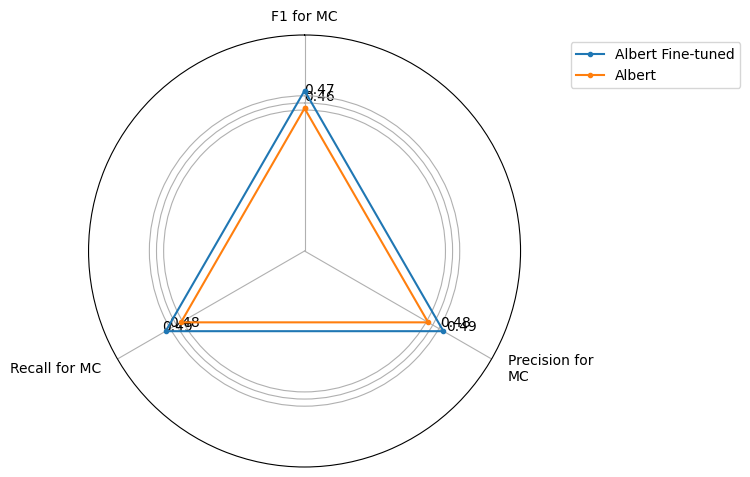

<Figure size 800x800 with 0 Axes>

In [ ]:
# Albert radar plot
# Drop the 'Model' and 'Accuracy for TEXT' columns from the results dataframe as they are not needed for the radar plot
data = albert_results.drop(columns=["Model", "Accuracy for TEXT"])

# Keep only columns with more than one unique value to avoid including constant columns
data = data.loc[:, data.nunique() > 1]

# Set the fixed y-axis limits for the radar plot (adjustable as needed for better visualization)
fixed_ylim = (0.15, 0.6)

# Create configuration for the radar plot to prevent label overlap
config = {
    "theta_tick_lbls": {"fontsize": 10},  # Set font size for labels
    "theta_tick_lbls_pad": 3,  # Increase padding between labels and the plot to create more space
    "theta_tick_lbls_txt_wrap": 15,  # Wrap long text into multiple lines
    "rgrid_tick_lbls_args": {"fontsize": 10},  # Adjust fontsize for the grid ticks (numerical labels like 0.2, 0.4, etc.)
    "legend_loc": "upper left",  # Place the legend outside the plot area to avoid overlap
    "bbox_to_anchor": (1.1, 1),  # Move the legend outside the plot area
    "legend_args": {"fontsize": 10}  # Set the font size for the legend
}

# Create the radar plot using the filtered data and model names (using 'Model' column from albert_results)
plot = radar_plot(data=data, model_names=albert_results["Model"], config=config)

# Manually set y-axis limits for all axes of the radar plot to ensure consistency (scaling fix)
for ax in plot.axes:
    ax.set_ylim(fixed_ylim)

# Adjust figure size to give more space for the plot
plt.figure(figsize=(8, 8))

# Apply tight layout to avoid overlapping elements
plt.tight_layout()

# Show the plot for Albert and Albert Fine-tuned
plot.show()

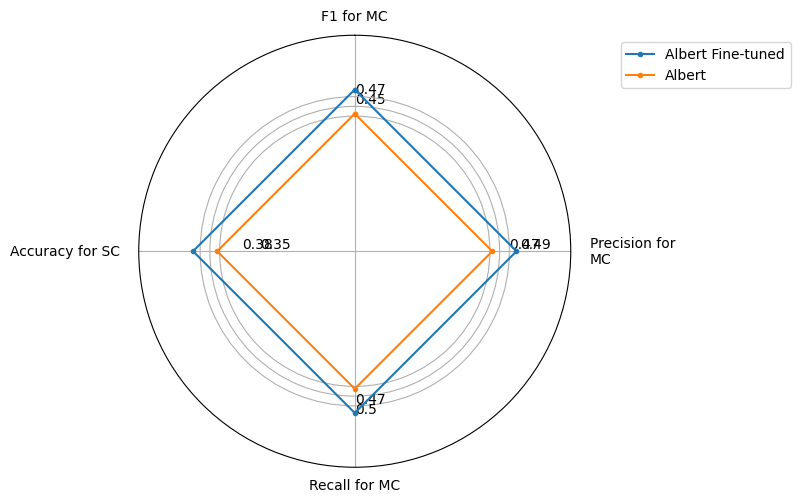

<Figure size 800x800 with 0 Axes>

In [ ]:
# BERT radar plot
# Drop the 'Model' and 'Accuracy for TEXT' columns from the results dataframe as they are not needed for the radar plot
data = bert_results.drop(columns=["Model", "Accuracy for TEXT"])

# Keep only columns with more than one unique value to avoid including constant columns
data = data.loc[:, data.nunique() > 1]

# Set the fixed y-axis limits for the radar plot (adjustable as needed for better visualization)
fixed_ylim = (0.15, 0.6)

# Create configuration for the radar plot to prevent label overlap
config = {
    "theta_tick_lbls": {"fontsize": 10},  # Set font size for labels
    "theta_tick_lbls_pad": 3,  # Increase padding between labels and the plot to create more space
    "theta_tick_lbls_txt_wrap": 15,  # Wrap long text into multiple lines
    "rgrid_tick_lbls_args": {"fontsize": 10},  # Adjust fontsize for the grid ticks (numerical labels like 0.2, 0.4, etc.)
    "legend_loc": "upper left",  # Place the legend outside the plot area to avoid overlap
    "bbox_to_anchor": (1.1, 1),  # Move the legend outside the plot area
    "legend_args": {"fontsize": 10}  # Set the font size for the legend
}

# Create the radar plot using the filtered data and model names (using 'Model' column from albert_results)
plot = radar_plot(data=data, model_names=albert_results["Model"], config=config)

# Manually set y-axis limits for all axes of the radar plot to ensure consistency (scaling fix)
for ax in plot.axes:
    ax.set_ylim(fixed_ylim)

# Adjust figure size to give more space for the plot
plt.figure(figsize=(8, 8))

# Apply tight layout to avoid overlapping elements
plt.tight_layout()

# Show the plot for Albert and Albert Fine-tuned
plot.show()

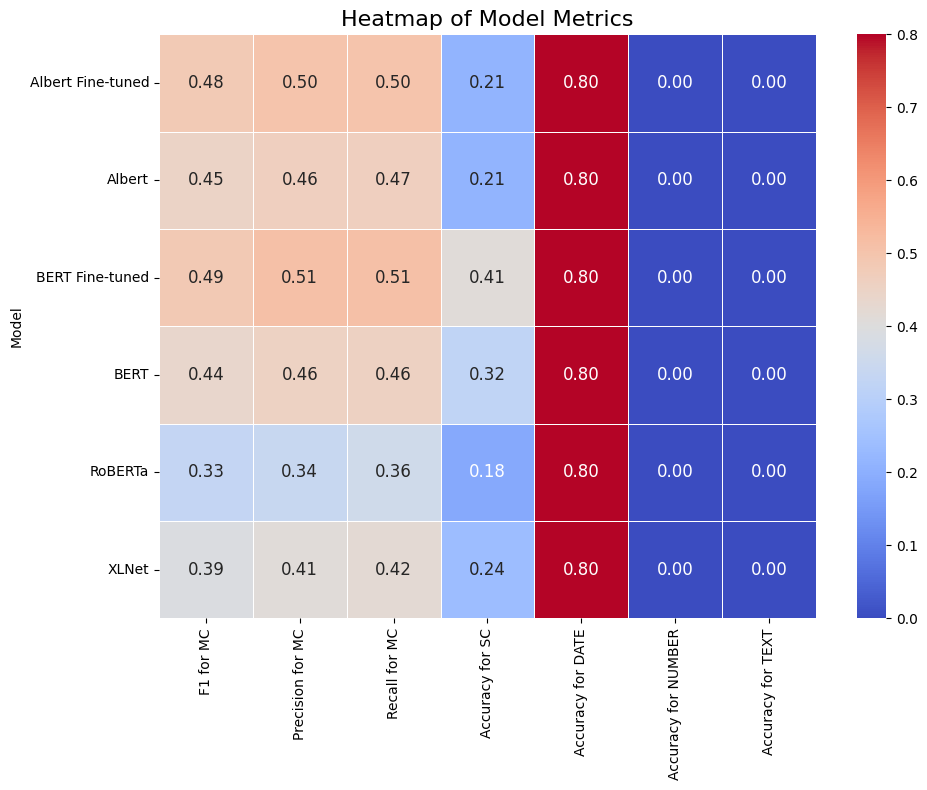

In [ ]:
# Create a copy of the results dataframe
results_heatmap = results_df.copy()

# Set the 'Model' column as the index so that it appears as row labels
results_heatmap.set_index('Model', inplace=True)

# Drop the 'index' column if it's still present (optional)
results_heatmap = results_heatmap.drop(columns=["index"], errors='ignore')

# Create a heatmap for the raw values
plt.figure(figsize=(10, 8))  # Increase figure size for better visualization
sns.heatmap(results_heatmap, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 12})

# Rotate the row labels (model names) by 90 degrees
plt.yticks(rotation=0)  # This keeps row labels horizontal
plt.xticks(rotation=90)  # Rotate column labels (metrics) 90 degrees for better readability

# Set the title and adjust the layout
plt.title("Heatmap of Model Metrics", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()


# Chapter 9: Conclusions
Created by: Alexander Keßler & Dominik Schuster

## Key Learnings

By tackling the project tasks we created a Q&A Dataset with the use of LLMs and made us familiar with machine learning.

Throughout this project, we successfully fine-tuned multiple-choice models for both single-select and multi-select questions. We explored various transformer-based architectures (e.g., BERT, ALBERT, XLNet, RoBERTa) and fine-tuned them using Hugging Face's Trainer. A major takeaway was understanding how tokenization, data collation, and model-specific nuances impact performance.

We also experimented with evaluation metrics, proper thresholding for multi-label classification, and debugging issues related to padding and bias in model predictions.

## What went well

*   Dataset creation and prompting: We were ably to create a Q&A dataset with good prompts that generated various contexts
*   Fine-tuning Process: The pipeline was designed efficiently, with dynamic padding, proper loss handling, and structured data processing.
*   Multi-Select Handling: Implementing a threshold-based selection strategy to account for multiple correct answers improved flexibility.
*   Use of Hugging Face Trainer: Allowed automated logging, evaluation, and model checkpointing, streamlining the training process.


## Challenges & Limitations

*   Data Collation Bias: The model initially preferred the first option due to the way padding was handled. This required careful debugging and improvements.
*   One-Hot to Multi-Class Transformation: Label formatting caused errors in evaluation, highlighting the importance of proper encoding.
*   Thresholding Strategy: Finding an optimal way to select multiple valid answers was challenging and required fine-tuning (mean + 40% of std deviation).
*   Computational Limitations: Training large transformer models required significant GPU resources, leading to potential memory constraints in Google Colab. We therefore only took relatively small models into account to avoid going into these troubles too much.
*   Working with git and GitHub the first time

## Further Improvements

But despite facing the limitations mentioned above, we could still improve our code and by that our results.
Additionally, the task we are now fulfilling with the model lacks in empirical realism, since we don't see an additional value in executing a survey and asking question by question.
It would be just as easy as filling out the survey as one would have done before.

So yes, there are some improvements to make.
With the following list, we want to share our thoughts on that:


1.   We didn't have a more difficult context than "easy". Having these we could train the models on harder tasks to get even better
2.   We didn't include the possibility of taking no option in the model output despite having these kind of intended answers in the QA-dataset
3.   As we mentioned in model_choice_and_fine_tuning.ipynb, it would be better to train on single select questions at first, then on multi select questions, because metric function can't differ between both in one training loop
4.   Increase Dataset Size & Diversity: Augmenting training data with more diverse question structures.
5.   Refine the Multi-Select Thresholding: Experimenting with dynamic thresholds based on per-question logits distribution.
6.   Address Padding Bias More Rigorously: Implementing alternate padding techniques to avoid biases in answer selection.

## Final Thoughts

Overall, this project was a deep dive into fine-tuning transformer models for multiple-choice questions. While we encountered challenges, each issue led to valuable learning experiences. Future improvements could focus on model selection, preprocessing, and evaluation to create a more robust system. 🚀
